In [4]:
pip install pandas pycoingecko scikit-learn keras matplotlib

**Import Libraries and Initialize API Client**

In [5]:
from pycoingecko import CoinGeckoAPI
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np


**Fetch Historical Data from CoinGecko**

In [6]:
# Initialize the API client
cg = CoinGeckoAPI()

# Fetch historical market data for a specific cryptocurrency
def fetch_historical_data(crypto_id, days=30):
    data = cg.get_coin_market_chart_by_id(id=crypto_id, vs_currency='usd', days=days)
    return data['prices']  # Returns the price history (timestamp, price)

# Fetch 30 days of Bitcoin price history
bitcoin_history = fetch_historical_data('bitcoin', days=30)

# Create DataFrame from fetched data
df = pd.DataFrame(bitcoin_history, columns=['Timestamp', 'Price'])

# Convert the timestamp to a readable date format
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')

# Print the first few rows of the DataFrame to verify the data
print(df.head())


                Timestamp         Price
0 2024-09-17 19:12:21.842  60563.415831
1 2024-09-17 20:18:19.992  59973.950621
2 2024-09-17 21:29:08.124  60375.036955
3 2024-09-17 22:28:22.530  60174.666225
4 2024-09-17 23:27:29.414  60155.644117


**Plot the Price Data**

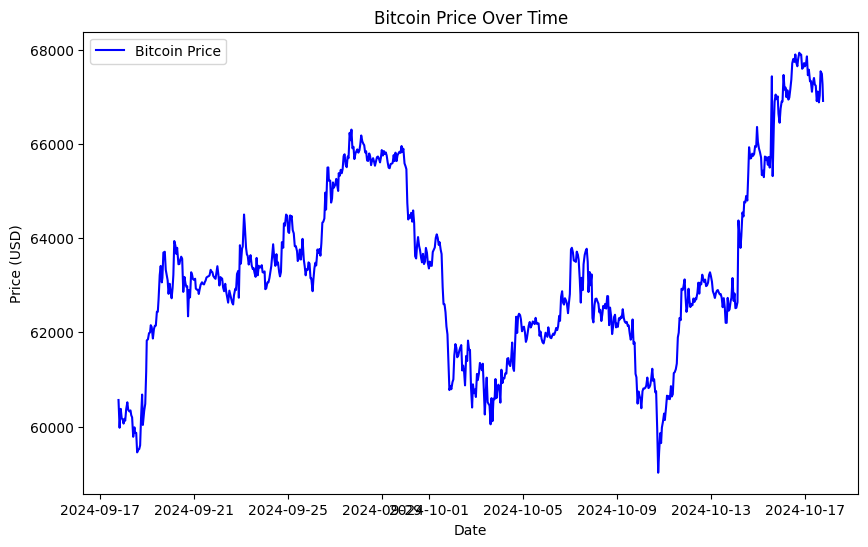

In [7]:
# Plot the price data
plt.figure(figsize=(10, 6))
plt.plot(df['Timestamp'], df['Price'], color='blue', label='Bitcoin Price')
plt.title('Bitcoin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()


**Preprocess the Data**

This involves scaling the prices between 0 and 1 and creating sequences of price data to use as input for the LSTM model.

cale the data using MinMaxScaler.
Create sequences of the last 60 days to predict the next day’s price.

In [8]:
# Extract the 'Price' column and reshape it for scaling
prices = df['Price'].values.reshape(-1, 1)

# Scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Create a DataFrame of scaled prices
df_scaled = pd.DataFrame(scaled_prices, columns=['Scaled Price'])

# Define a function to create sequences of 60 days' prices for LSTM input
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])  # Sequence of 60 previous days
        y.append(data[i, 0])  # Price on the 61st day
    return np.array(X), np.array(y)

# Create sequences from the scaled prices
seq_length = 60
X, y = create_sequences(scaled_prices, seq_length)

# Reshape the data for LSTM input (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")


Training data shape: (528, 60, 1), Testing data shape: (133, 60, 1)


**Build the LSTM Model**

In [9]:
# Build the LSTM model
model = Sequential()

# Add LSTM layers with Dropout to prevent overfitting
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer with one unit for predicting the price
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0998
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0125
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0073
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0051
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0056
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0050
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0062
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0062
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0045
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0044


**Evaluate the Model**

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


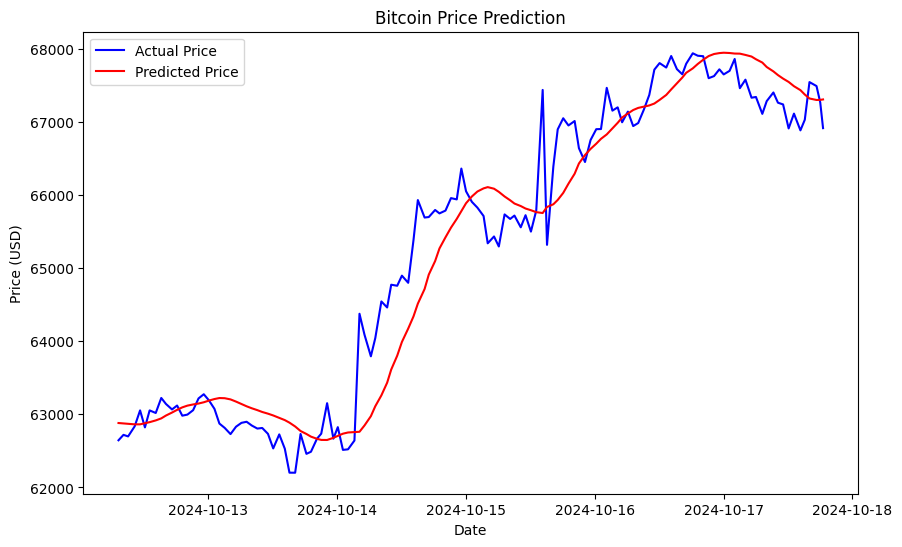

Root Mean Squared Error: 512.7632134131337


In [10]:
# Predict prices on the test set
predicted_prices = model.predict(X_test)

# Rescale the predicted prices back to the original range
predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the real vs predicted prices
plt.figure(figsize=(10, 6))
plt.plot(df['Timestamp'][-len(y_test):], y_test_rescaled, color='blue', label='Actual Price')
plt.plot(df['Timestamp'][-len(y_test):], predicted_prices, color='red', label='Predicted Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Calculate the root mean squared error (RMSE)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predicted_prices))
print(f'Root Mean Squared Error: {rmse}')
